In [20]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

hr:  1.8666666666666667


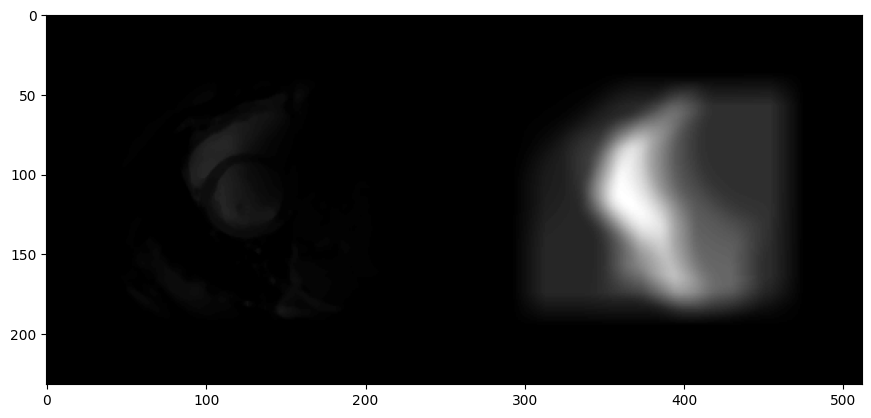

In [21]:
Tps = 0
Slice = 11//3

num = 6




def load_patient(num):
    with open(f'database/patient{num:03}/info.cfg') as f:
        info = [line.replace("\n", "").replace(":", "").split(" ") for line in f]
        for i in range(len(info)):
            if info[i][1].isnumeric():
                info[i][1] = int(info[i][1])

    patient = tio.Subject(
        img=tio.ScalarImage(f'database/patient{num:03}/patient{num:03}_4d.nii.gz'),
        gt=tio.LabelMap(f'database/patient{num:03}/patient{num:03}_frame{dict(info)["ED"]:02}_gt.nii.gz'),
        info = dict(info)
    )
    return patient



def normalize(img4d):
    hist = torch.linspace(0, 1, img4d.shape[1]*img4d.shape[2]*img4d.shape[3])
    hist = torch.pow(hist, 5)*(6-5*hist)
    for t in range(img4d.shape[0]):
        indexs = torch.unravel_index(torch.argsort(img4d[t].flatten()), img4d[t].shape)
        img4d[t][indexs] = hist

def tf_mask2(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.ifft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(75,75))

    #mask = cv2.medianBlur(mask,3)
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(75,75)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))
   
    


    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m, mask

patient = load_patient(num)
t_img = patient.img.data.clone().detach()
img_m, mask = tf_mask2(t_img, heartrate=t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))
#normalize(t_img)
plt.figure().set_figwidth(15)
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')
plt.imshow(np.concatenate([img_m, mask], axis=1), cmap='gray')

print("hr: ", t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))

In [64]:
def patient_metrics(patient, circles, Slice=Slice):
    t_gt = torch.tensor(patient.gt.data)
    center = (t_gt[0, :, :, Slice]==3).argwhere().mean(axis=0, dtype=torch.float32)
    if circles is None:
        return False, 0., False
    
    dist = torch.dist(center, torch.tensor(circles[:2])) 
    gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)
    hit =  (gt_map[0, int(circles[1]), int(circles[0]), Slice] == 3)
    return True, dist, hit

In [65]:
def tf_mask(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)

    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(59,59))
    #mask = cv2.dilate(mask, kernel, 1)
    #mask = cv2.dilate(mask, kernel, 1)
    #mask = cv2.erode(mask, kernel, 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    #mask = cv2.erode(mask, kernel, 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    #mask = cv2.blur(mask,(21, 21))

    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(119,119)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(130,130)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m


In [144]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    
    cv2.circle(cimg,(circles[0],circles[1]),circles[2],(0,255,0),1)
    cv2.circle(cimg,(circles[0],circles[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

def draw_region(imageRGB, lv_seg):
  le_contour = lv_seg - cv2.erode(lv_seg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
  lv_seg = np.bool_(lv_seg)
  le_contour = np.bool_(le_contour)
  imageRGB[lv_seg, 2] = 100
  imageRGB[le_contour, 2] = 255
  return imageRGB

In [67]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image):
    param_min = 0
    param_max = 200
    for _ in range(12):
        param_mean = (param_min + param_max) / 2
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
        
        elif circles is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return None

def best_hough_max(image, param_min=0, param_max=200, max_iter=10):
    param_min = param_min
    param_max = param_max
    out_circles = None
    for _ in range(max_iter):
        param_mean = (param_min + param_max) / 2
        circle = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circle is not None and len(circle[0])==1:
            out_circles = circle[0][0]
            param_min = param_mean

        elif circle is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return out_circles

def best_hough2(image):
    for param1 in range(180, 20, -10):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=1,maxRadius=50)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
    return None

def best_hough3(image): # iterate + max dicothomie
    step = 10
    for param1 in range(180, 20, -step):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=1,maxRadius=50)
        
        if circles is not None:
            for param in range(param1+step, param1, -1):
                circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                    param1=param,param2=param/2,minRadius=1,maxRadius=50)
                if circles is not None and len(circles[0])==1:
                    return circles[0][0]
            #return best_hough_max(image, param_max=param1+step, param_min=param1, max_iter=10)
    return None

In [68]:
def find_seed(patient, Slice=Slice):
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    #normalize(t_img)
    hr = t_img.shape[0] / (patient.info["ES"] - patient.info["ED"])
    img_m = tf_mask(t_img, heartrate=hr, Slice=Slice)
    circles = best_hough3(img_m)
    return circles



def recherche_cercles(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    rad = []
    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        slice = t_img.shape[3] // 2
        circles = find_seed(patient, Slice=slice)
        c_img = draw_cercles(t_img, circles, Slice=slice)
        found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

        miss += not found
        avg_dist += dist 
        accuracie += hit 

        cv2.imwrite(f'test/cercles_{i:03d}.png', c_img)
    avg_dist /= nb - miss
    print(f"\n-= results =-\n accuracie: {accuracie / nb * 100}% (over found circles: {accuracie / (nb-miss) * 100})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


In [69]:
recherche_cercles(10)

C:\Users\debat\AppData\Local\Temp\ipykernel_10092\2194599897.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_10092\2194599897.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_10092\3216853665.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)



-= results =-
 accuracie: 100.0% (over found circles: 100.0)
 miss: 0 
 avg dist: 35.237518310546875
-===========-


# LV Segmentation

In [159]:
def region_growth(image,seed,error=10):
    H,L=image.shape
    left_V = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    regionplus=[seed]
    start_moy = []
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            start_moy += [image[seed[1]+i,seed[0]+j]]
    moy = np.median(start_moy)
     
    visited[seed[1],seed[0]]=True
    left_V[seed[1],seed[0]]=1

    while regionplus:
        new_p=[]
        for (x,y) in regionplus:
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx,ny=x+dx,y+dy
                    if 0<=nx<L and 0<=ny<H and not visited[ny,nx]:
                        if abs(image[ny,nx]-moy)<error:
                            new_p.append((nx,ny))
                            visited[ny,nx]=True
                            left_V[ny,nx]=1
        regionplus.extend(new_p)
        if new_p:
            total_intensity=sum(image[ny,nx] for (nx,ny) in regionplus)
            moy=total_intensity/len(regionplus)
        regionplus=new_p
    taille = np.sum(left_V)
    return left_V, taille

In [166]:
def leftv_seg(patient, error=10, Tps=Tps, Slice=Slice):
    seed = find_seed(patient, Slice=Slice)
    if seed is None:
        return None
    
    seed = (int(seed[0]), int(seed[1]))
    t_img = torch.tensor(patient.img.data)
    treshold = 0
    lv_seg, last_taille = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, treshold)
    sizes = []

    step = 8
    for treshold in range(5, 100, step):
        lv_seg, taille = region_growth(np.array(t_img[Tps,:,:,Slice]), seed, treshold)
        sizes += [(taille - last_taille, treshold-step)]
        last_taille = taille

    treshold = max(sizes)[1]
    _, last_taille = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, treshold)
    sizes = []
    for treshold2 in range(treshold, treshold+step):
        lv_seg, taille = region_growth(np.array(t_img[Tps,:,:,Slice]), seed, treshold2)
        sizes += [(taille - last_taille, treshold2-1)]
        last_taille = taille

    treshold = max(sizes)[1]
    lv_seg, taille = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, treshold)
    return lv_seg

In [167]:
def recherche_lv(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    rad = []
    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        slice = t_img.shape[3] // 2
        circles = find_seed(patient, Slice=slice)
        lv_seg = leftv_seg(patient, Slice=slice)
        c_img = draw_cercles(t_img, circles, Slice=slice)
        c_img = draw_region(c_img, lv_seg)
        found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

        miss += not found
        avg_dist += dist 
        accuracie += hit 

        
        cv2.imwrite(f'test/cercles_{i:03d}.png', c_img)
    avg_dist /= nb - miss
    print(f"\n-= results =-\n accuracie: {accuracie / nb * 100}% (over found circles: {accuracie / (nb-miss) * 100})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


In [168]:
recherche_lv(10)

C:\Users\debat\AppData\Local\Temp\ipykernel_10092\2293256762.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_10092\2194599897.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_10092\2225522310.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data)



-= results =-
 accuracie: 100.0% (over found circles: 100.0)
 miss: 0 
 avg dist: 35.237518310546875
-===========-
